# Using CellTypist for cell type classification
This notebook is adapted from the [Celltypist tutorial notebook](https://colab.research.google.com/github/Teichlab/celltypist/blob/main/docs/notebook/celltypist_tutorial.ipynb) by Teichlab.
This notebook showcases the cell type classification for scRNA-seq query data by retrieving the most likely cell type labels from either the built-in CellTypist models or the user-trained custom models.

Use the tmp_celltypist environment

In [1]:
import numpy as np
import scanpy as sc
import pandas as pd
import celltypist
from celltypist import models

In [2]:

cells_adata_path = "/srv/gstore/projects/p37785/EzPyzENACTApp_2025-07-01--10-40-29/ENACTApp_VisiumHD_ResusM_Kidney/chunks/weighted_by_area/celltypist_results/cells_adata.h5"

model_name = "Cells_Human_Tonsil.pkl"


In [3]:
adata = sc.read_h5ad(cells_adata_path)

In [4]:
adata

AnnData object with n_obs × n_vars = 147302 × 18085
    obs: 'cell_type', 'patch_id'
    obsm: 'spatial', 'stats'

In [5]:
adata.obsm['stats']

,num_shared_bins,num_unique_bins,num_transcripts
id,,,
ID_1,12,54,584
ID_10,29,64,10589
ID_100,23,59,3147
ID_1000,24,18,1584
ID_10000,22,23,2597
...,...,...,...
ID_146663,25,27,6014
ID_146716,17,35,3858
ID_146737,9,16,565


This dataset includes 2,000 cells and 18,950 genes collected from different studies, thereby showing the practical applicability of CellTypist.

In [6]:
adata.shape

(147302, 18085)

The expression matrix (`adata.X`) is pre-processed (and required) as log1p normalised expression to 10,000 counts per cell (this matrix can be alternatively stashed in `.raw.X`).

In [7]:
adata.X.expm1().sum(axis = 1)

matrix([[3.5883919e+05],
        [          inf],
        [1.9036923e+23],
        ...,
        [1.5237356e+14],
        [1.4337739e+12],
        [          inf]], shape=(147302, 1), dtype=float32)

Some pre-assigned cell type labels are also in the data, which will be compared to the predicted labels from CellTypist later.

In [8]:
adata

AnnData object with n_obs × n_vars = 147302 × 18085
    obs: 'cell_type', 'patch_id'
    obsm: 'spatial', 'stats'

In [9]:
lib_size = adata.X.sum(1)
adata.obs["size_factor"] = lib_size / np.mean(lib_size)
adata.obs["lib_size"] = lib_size

In [10]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [11]:
adata.X.expm1().sum(axis = 1)

matrix([[10000.   ],
        [10000.   ],
        [ 9999.998],
        ...,
        [ 9999.999],
        [10000.001],
        [10000.001]], shape=(147302, 1), dtype=float32)

In [12]:
adata.obs

,cell_type,patch_id,size_factor,lib_size
id,,,,
ID_1,nbc,patch_0_0.csv,0.111358,584.722717
ID_10,pb,patch_0_0.csv,2.016809,10589.914062
ID_100,nbc,patch_0_0.csv,0.599362,3147.147217
ID_1000,cm pre-non-tfh,patch_0_0.csv,0.301803,1584.713745
ID_10000,cm pre-non-tfh,patch_0_0.csv,0.494601,2597.063477
...,...,...,...,...
ID_146663,early gc-commited nbc,patch_1_3.csv,1.145425,6014.426270
ID_146716,gc-commited nbc,patch_1_3.csv,0.734755,3858.070312
ID_146737,nbc,patch_1_3.csv,0.107648,565.238892


## Assign cell type labels using a CellTypist built-in model
In this section, we show the procedure of transferring cell type labels from built-in models to the query dataset.

Download the latest CellTypist models.

In [13]:
# Enabling `force_update = True` will overwrite existing (old) models.
models.download_models(force_update = True)

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 54
📂 Storing models in /home/degottardiraphael/.celltypist/data/models
💾 Downloading model [1/54]: Immune_All_Low.pkl
💾 Downloading model [2/54]: Immune_All_High.pkl
💾 Downloading model [3/54]: Adult_COVID19_PBMC.pkl
💾 Downloading model [4/54]: Adult_CynomolgusMacaque_Hippocampus.pkl
💾 Downloading model [5/54]: Adult_Human_MTG.pkl
💾 Downloading model [6/54]: Adult_Human_PancreaticIslet.pkl
💾 Downloading model [7/54]: Adult_Human_PrefrontalCortex.pkl
💾 Downloading model [8/54]: Adult_Human_Skin.pkl
💾 Downloading model [9/54]: Adult_Human_Vascular.pkl
💾 Downloading model [10/54]: Adult_Mouse_Gut.pkl
💾 Downloading model [11/54]: Adult_Mouse_OlfactoryBulb.pkl
💾 Downloading model [12/54]: Adult_Pig_Hippocampus.pkl
💾 Downloading model [13/54]: Adult_RhesusMacaque_Hippocampus.pkl
💾 Downloading model [14/54]: Autopsy_COVID19_Lung.pkl
💾 Downloading model [15/54]: COVID19_HumanChall

All models are stored in `models.models_path`.

Get an overview of the models and what they represent.

Choose the model you want to employ, for example, the model with all tissues combined containing low-hierarchy (high-resolution) immune cell types/subtypes.

Transfer cell type labels from this model to the query dataset using [celltypist.annotate](https://celltypist.readthedocs.io/en/latest/celltypist.annotate.html).

In [14]:
# Not run; predict cell identities using this loaded model.
#predictions = celltypist.annotate(adata, model = model, majority_voting = True)
# Alternatively, just specify the model name (recommended as this ensures the model is intact every time it is loaded).
predictions = celltypist.annotate(adata, model = model_name, majority_voting = True)

🔬 Input data has 147302 cells and 18085 genes
🔗 Matching reference genes in the model
🧬 4318 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, will construct one before the over-clustering
/misc/ngseq12/miniforge3/envs/tmp_celltypist/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
⛓️ Over-clustering input data with resolution set to 25
🗳️ Majority voting the predictions
✅ Majority voting done!


By default (`majority_voting = False`), CellTypist will infer the identity of each query cell independently. This leads to raw predicted cell type labels, and usually finishes within seconds or minutes depending on the size of the query data. You can also turn on the majority-voting classifier (`majority_voting = True`), which refines cell identities within local subclusters after an over-clustering approach at the cost of increased runtime.

The results include both predicted cell type labels (`predicted_labels`), over-clustering result (`over_clustering`), and predicted labels after majority voting in local subclusters (`majority_voting`). Note in the `predicted_labels`, each query cell gets its inferred label by choosing the most probable cell type among all possible cell types in the given model.

In [15]:
predictions.predicted_labels

,predicted_labels,over_clustering,majority_voting
id,,,
ID_1,NBC,464,NBC
ID_10,DZ late Sphase,44,cycling FDC
ID_100,ncsMBC FCRL4/5+,432,Early GC-commited NBC
ID_1000,Tfh-LZ-GC,497,CM PreTfh
ID_10000,CM Pre-non-Tfh,125,aDC1
...,...,...,...
ID_146663,cycling FDC,532,Early MBC
ID_146716,cycling FDC,370,Reactivated proliferative MBCs
ID_146737,Basal cells,187,NBC


Transform the prediction result into an `AnnData`.

In [16]:
# Get an `AnnData` with predicted labels embedded into the cell metadata columns.
adata = predictions.to_adata()

Compared to `adata`, the new `adata` has additional prediction information in `adata.obs` (`predicted_labels`, `over_clustering`, `majority_voting` and `conf_score`). Of note, all these columns can be prefixed with a specific string by setting `prefix` in [to_adata](https://celltypist.readthedocs.io/en/latest/celltypist.classifier.AnnotationResult.html#celltypist.classifier.AnnotationResult.to_adata).

In [17]:
adata.obs

,cell_type,patch_id,size_factor,lib_size,predicted_labels,over_clustering,majority_voting,conf_score
id,,,,,,,,
ID_1,nbc,patch_0_0.csv,0.111358,584.722717,NBC,464,NBC,0.065704
ID_10,pb,patch_0_0.csv,2.016809,10589.914062,DZ late Sphase,44,cycling FDC,0.417705
ID_100,nbc,patch_0_0.csv,0.599362,3147.147217,ncsMBC FCRL4/5+,432,Early GC-commited NBC,0.263028
ID_1000,cm pre-non-tfh,patch_0_0.csv,0.301803,1584.713745,Tfh-LZ-GC,497,CM PreTfh,0.068869
ID_10000,cm pre-non-tfh,patch_0_0.csv,0.494601,2597.063477,CM Pre-non-Tfh,125,aDC1,0.039881
...,...,...,...,...,...,...,...,...
ID_146663,early gc-commited nbc,patch_1_3.csv,1.145425,6014.426270,cycling FDC,532,Early MBC,0.792837
ID_146716,gc-commited nbc,patch_1_3.csv,0.734755,3858.070312,cycling FDC,370,Reactivated proliferative MBCs,0.013179
ID_146737,nbc,patch_1_3.csv,0.107648,565.238892,Basal cells,187,NBC,0.061029


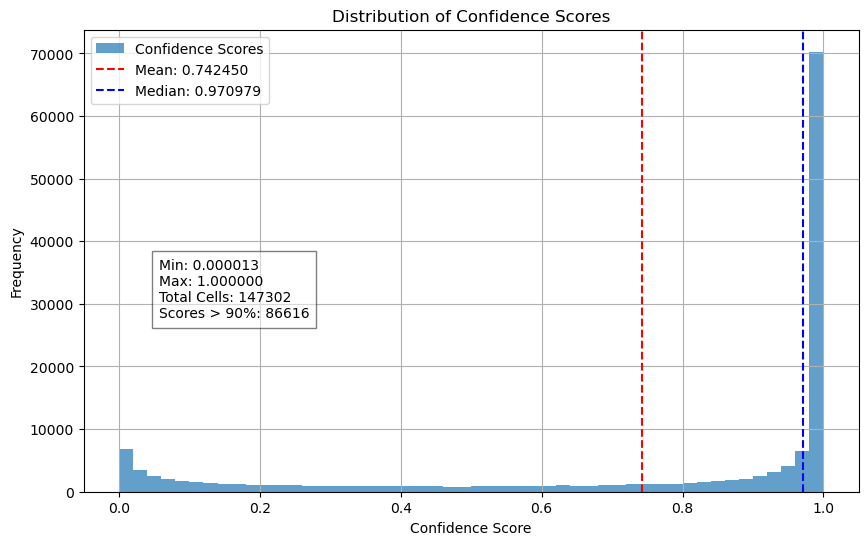

In [18]:
import matplotlib.pyplot as plt

# Calculate mean, median, and total number of cells
mean_conf_score = adata.obs['conf_score'].mean()
median_conf_score = adata.obs['conf_score'].median()
total_cells = adata.obs['conf_score'].shape[0]

# Plot histogram
adata.obs['conf_score'].hist(bins=50, figsize=(10, 6), alpha=0.7, label='Confidence Scores')
plt.axvline(mean_conf_score, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean: {mean_conf_score:.6f}')
plt.axvline(median_conf_score, color='blue', linestyle='dashed', linewidth=1.5, label=f'Median: {median_conf_score:.6f}')
plt.title('Distribution of Confidence Scores')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.legend()

# Display summary metrics
num_scores_above_90 = (adata.obs['conf_score'] > 0.9).sum()
summary_text = (
    f"Min: {adata.obs['conf_score'].min():.6f}\n"
    f"Max: {adata.obs['conf_score'].max():.6f}\n"
    f"Total Cells: {total_cells}\n"
    f"Scores > 90%: {num_scores_above_90}"
)
plt.figtext(0.2, 0.4, summary_text, fontsize=10, bbox={"facecolor": "white", "alpha": 0.5, "pad": 5})

plt.show()

Compare the different celltypist models on this dataset

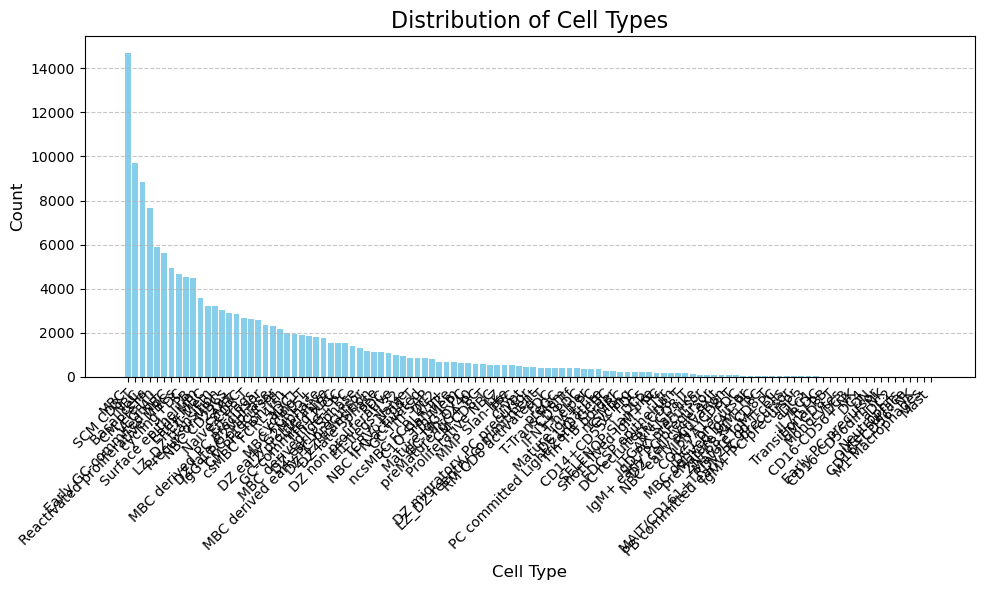

In [19]:
cell_type_counts = adata.obs["predicted_labels"].value_counts().reset_index()
cell_type_counts.columns = ["Cell Type pred", "Count"]

# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(cell_type_counts["Cell Type pred"], cell_type_counts["Count"], color='skyblue')
plt.title("Distribution of Cell Types", fontsize=16)
plt.xlabel("Cell Type", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

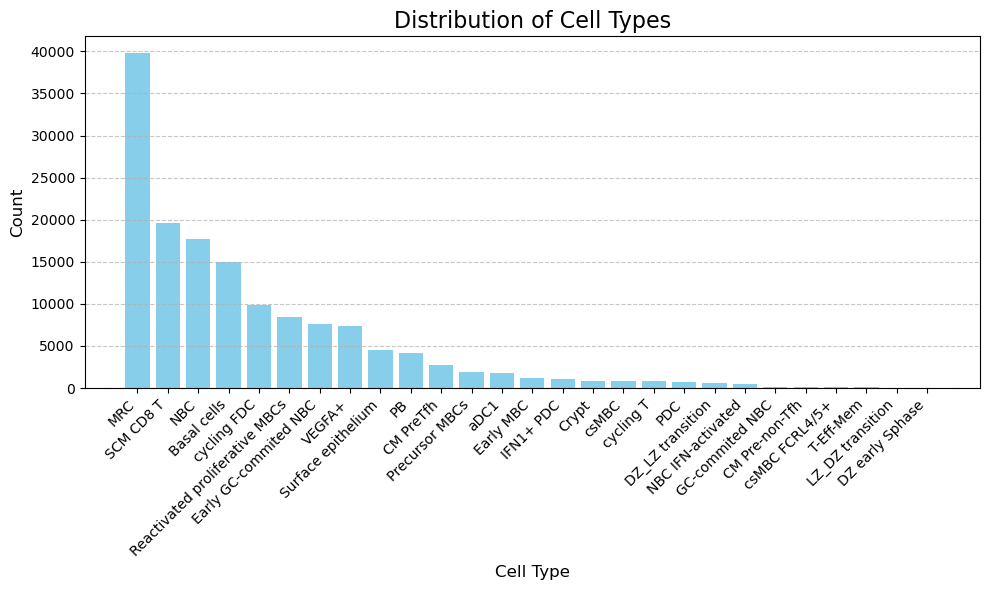

In [20]:
cell_type_counts = adata.obs["majority_voting"].value_counts().reset_index()
cell_type_counts.columns = ["Cell Type MV", "Count"]

# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(cell_type_counts["Cell Type MV"], cell_type_counts["Count"], color='skyblue')
plt.title("Distribution of Cell Types", fontsize=16)
plt.xlabel("Cell Type", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

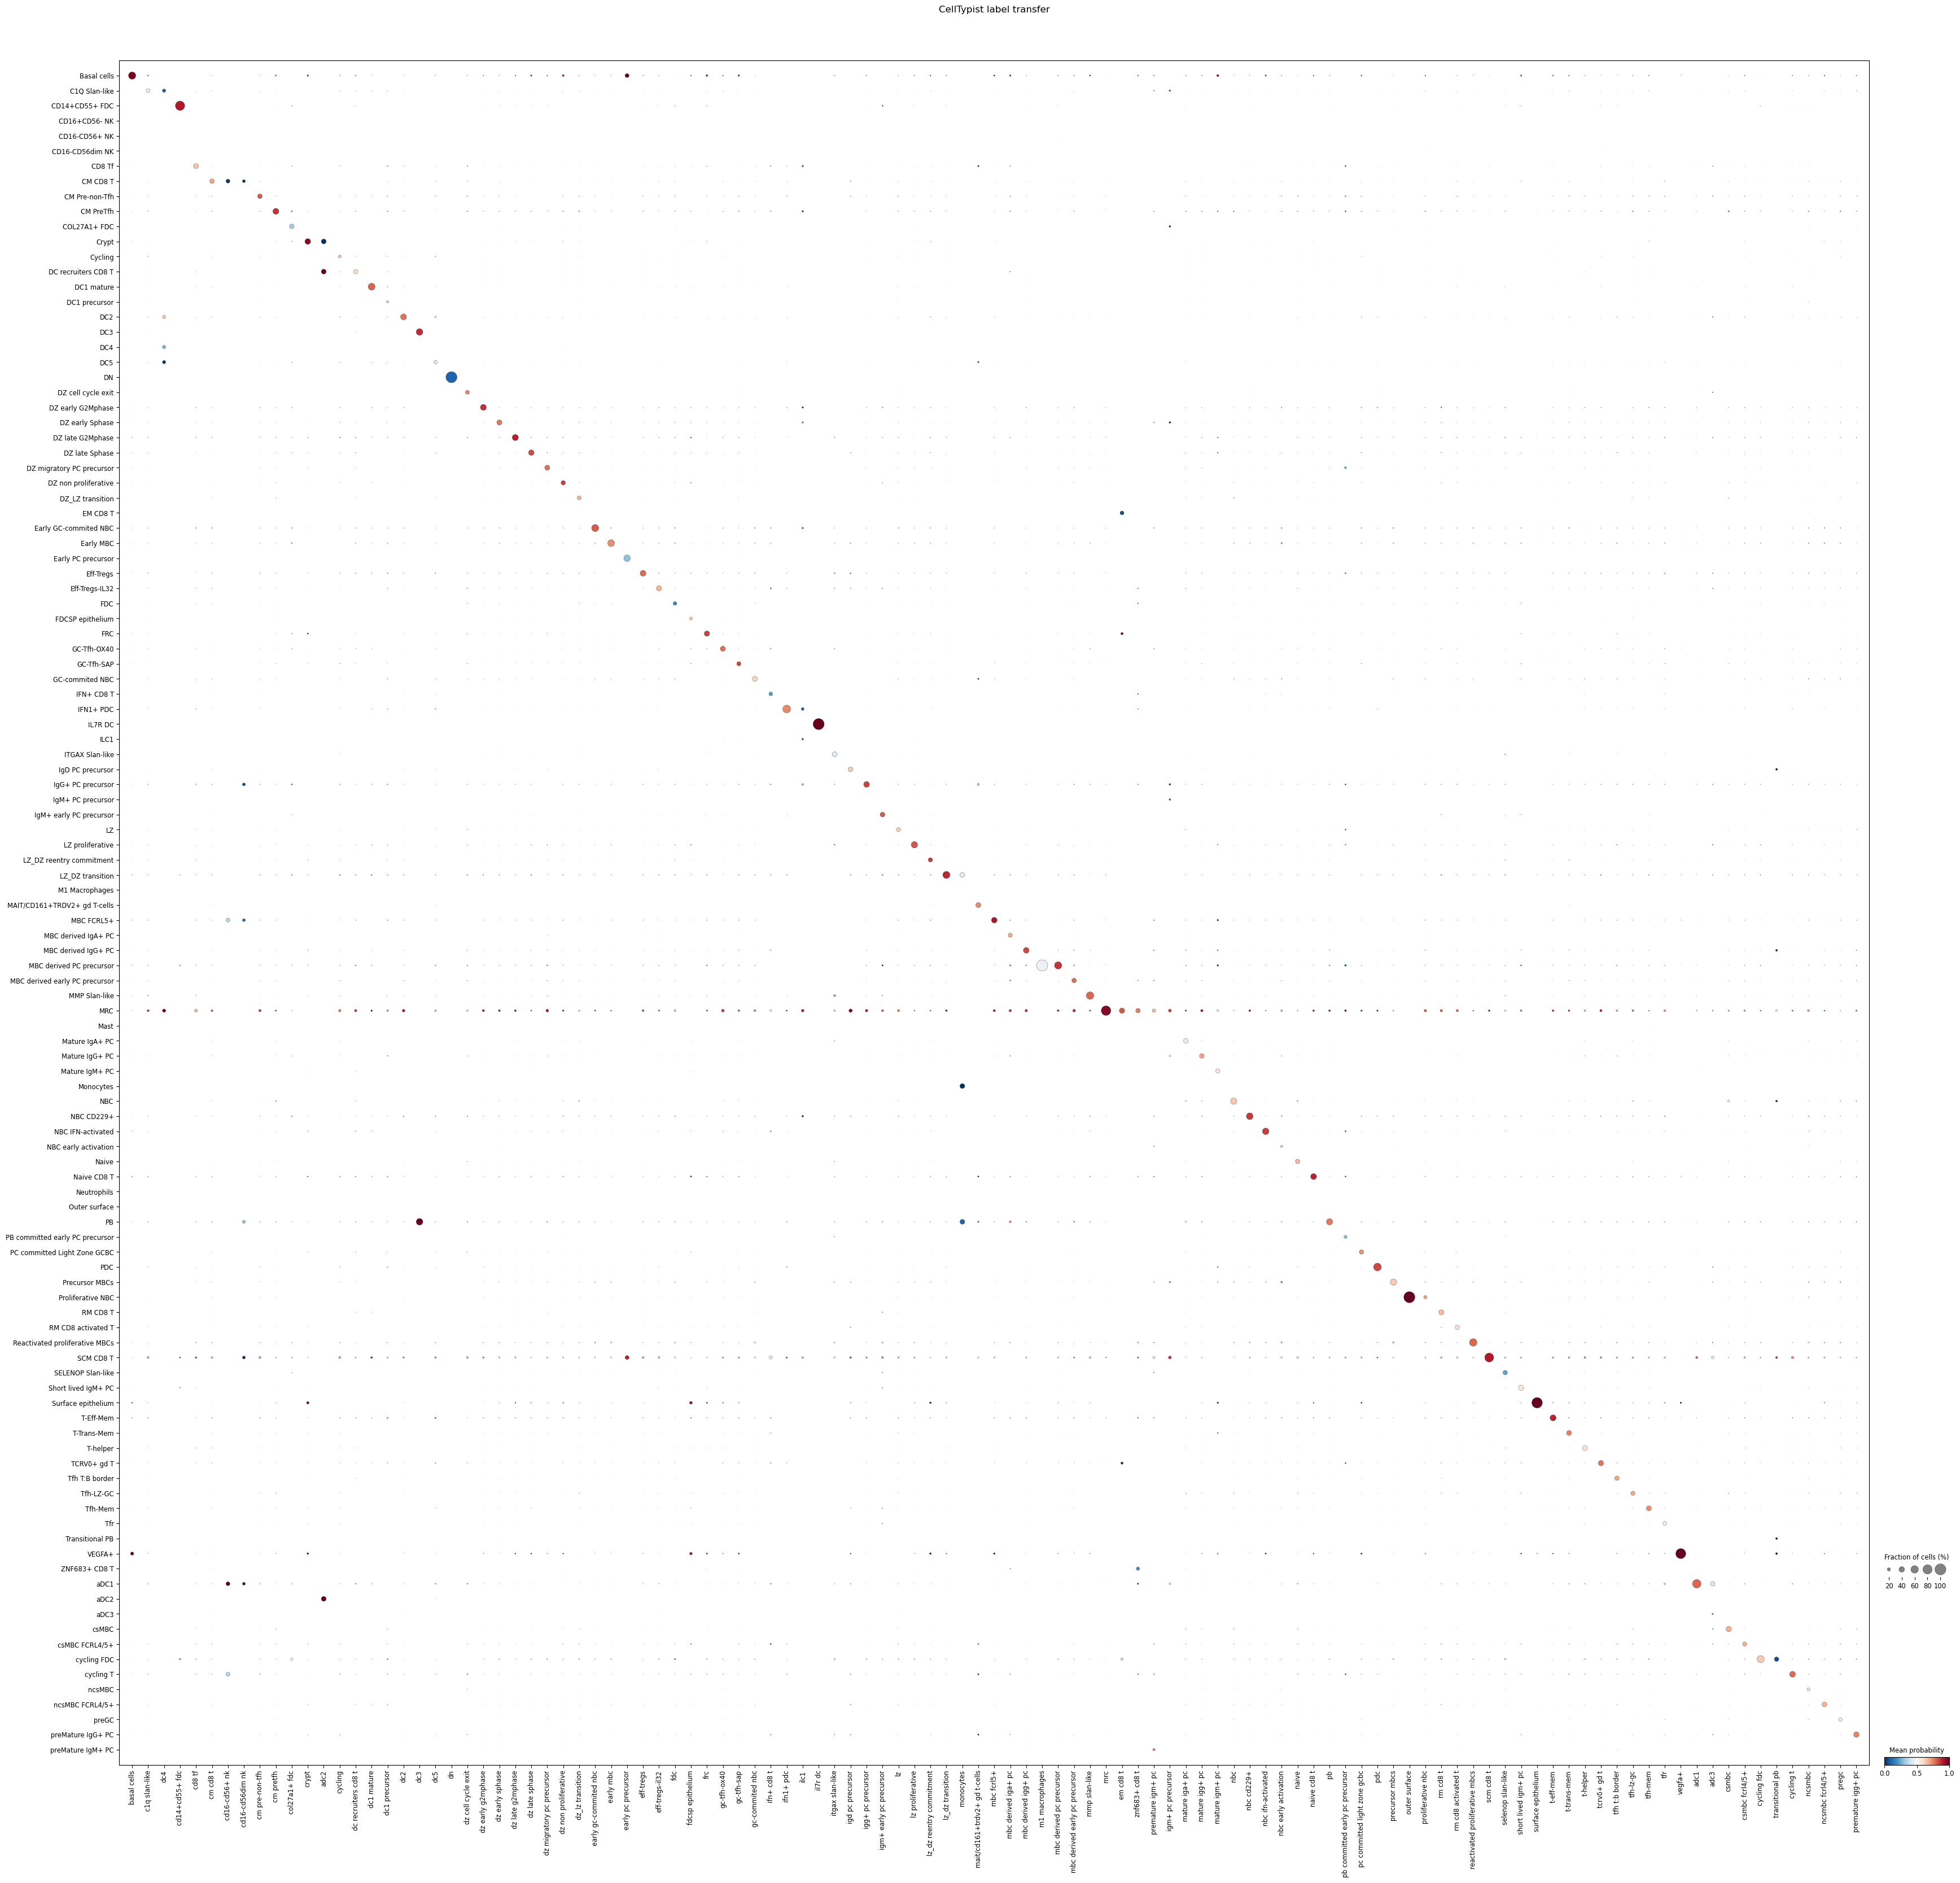

In [21]:
celltypist.dotplot(predictions, use_as_reference = 'cell_type', use_as_prediction = 'predicted_labels') #predictions are on the y axis

# Thesis outputs

In [ ]:
model_name = 'Tonsil'
# Save the whole array of confidence scores as a new column in the CSV, named after the model
conf_scores = adata.obs['conf_score']


In [ ]:
csv_path = '/home/degottardiraphael/MasterThesis/Benchmarking pipeline/CellTypeAssignment metrics/Celltypist/Celltypist_confidence_scores.csv'
df_csv = pd.read_csv(csv_path)
# Ensure the lengths match before assignment
if len(df_csv) == len(conf_scores):
    df_csv[model_name] = conf_scores.values
else:
    print(f"Length mismatch: df_csv has {len(df_csv)} rows, conf_scores has {len(conf_scores)} rows.")
    # Fill the remaining rows with NaN for the new column
    df_csv[model_name] = pd.Series(conf_scores.values).reindex(df_csv.index)
print(df_csv.head())


     Bin8x8  Bin2Cell     Enact    Tonsil
0  0.173920  0.415195  0.062796  0.065704
1  0.111783  0.308685  0.028867  0.417705
2  0.653658  0.219721  0.031286  0.263028
3  0.790891  0.318133  0.050490  0.068869
4  0.189795  0.124476  0.199702  0.039881


In [ ]:
#df_csv.to_csv(csv_path, index=False)